In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import random
import cv2
import sys
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def load_from_dataset (path , img_size_w , img_size_h):
  data = []
  for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img,(img_size_w,img_size_h))
    data.append(img)
  return data

In [4]:
class Data(Dataset):
    def __init__(self, device, img_size_w = 224, img_size_h = 224, mode='train', train_transform=None, val_transform=None):
        self.img_size_w = img_size_w

        self.img_size_h = img_size_h

        self.X_train, self.y_train, self.X_test, self.y_test = None, None, None, None

        self.mode = mode

        benign_path = "../data/benign/*.jpg"
        malignant_path = "../data/malignant/*.jpg"

        benign = load_from_dataset (benign_path , img_size_w , img_size_h)
        malignant = load_from_dataset (malignant_path , img_size_w , img_size_h)

        benign = np.array(benign , dtype=np.float32)
        malignant = np.array(malignant , dtype=np.float32)
        print (f'dataset shape is : {benign.shape}')

        benign_labels = np.zeros(benign.shape[0], dtype=np.float32)
        malignant_labels = np.full(malignant.shape[0], 1.0)

        self.images = np.concatenate((benign, malignant), axis=0)
        self.labels = np.concatenate((benign_labels, malignant_labels))

        self.train_transform = train_transform if train_transform else transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Resize((img_size_h, img_size_w)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.val_transform = val_transform if val_transform else transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Resize((img_size_h, img_size_w)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def train_val_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        if self.mode == 'train':
          return self.X_train.shape[0]
        elif self.mode == 'val':
          return self.X_test.shape[0]

    def __getitem__(self, idx):
        if self.mode == 'train':
            image, label = self.X_train[idx], self.y_train[idx]
            image = self.train_transform(image)
        elif self.mode == 'val':
            image, label = self.X_test[idx], self.y_test[idx]
            image = self.val_transform(image)

        label = torch.tensor(label, dtype=torch.float32).to(device)
        return {'image': image, 'label': label}

    def normalize(self):
        self.images = self.images/255.0

In [5]:
class ToTensorAndMove: 
    def __init__(self, device): 
        self.to_tensor = transforms.ToTensor() 
        self.device = device 
    def __call__(self, img): 
        tensor = self.to_tensor(img) 
        return tensor.to(self.device)

In [6]:
custom_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

custom_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    ToTensorAndMove(device),
])

In [7]:
class SkinCancerCNN(nn.Module):
    def __init__(self):
        super(SkinCancerCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1)  
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1) 
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=2)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(2 * 2 * 128, 64) 
        self.fc2 = nn.Linear(64, 32)  
        self.fc3 = nn.Linear(32, 2)   

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

In [8]:
in_channels = 3
num_classes = 2
learning_rate = 3e-4 # karpathy's constant
batch_size = 256
num_epochs = 100

In [9]:
model = SkinCancerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def train_model(model, optimizer, criterion, train_loader, val_loader, dataset, num_epochs=10, device='cuda'):
    model.to(device)
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)
    
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        dataset.mode = 'train'
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for batch in train_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)
                
                optimizer.zero_grad()  
                outputs = model(images)
                loss = criterion(outputs, labels.long())  
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)
                pbar.update(1)
        
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        # print(f"Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)
        
        model.eval()  
        dataset.mode = 'val'
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
                for batch in val_loader:
                    images, labels = batch['image'].to(device), batch['label'].to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels.long())
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                    pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)
                    pbar.update(1)
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100. * correct / total
        # print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        print("-" * 30)
        val_accuracies.append(val_accuracy)
        val_losses.append(avg_val_loss)
        mean_loss = sum(train_losses) / len(train_losses)
        mean_loss = round(mean_loss, 2)
        scheduler.step(mean_loss)
    
    return train_accuracies, train_losses, val_accuracies, val_losses


In [11]:
dataset = train_dataset = Data(device, img_size_w=28, img_size_h=28, mode='train', 
                               train_transform=custom_train_transform, val_transform=custom_val_transform)

dataset.normalize()
dataset.train_val_split()

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

dataset shape is : (1800, 28, 28, 3)


In [12]:
train_accuracies, train_losses, val_accuracy, val_losses = train_model(model, optimizer, criterion, 
                                                                       train_dataloader, test_dataloader, dataset, num_epochs=num_epochs, device=device)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 33.30batch/s, accuracy=65.8, loss=0.693]


------------------------------
Epoch [2/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 33.46batch/s, accuracy=56.8, loss=0.674]


------------------------------
Epoch [3/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 29.57batch/s, accuracy=56.8, loss=0.661]


------------------------------
Epoch [4/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 34.42batch/s, accuracy=57.7, loss=0.635]


------------------------------
Epoch [5/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 36.98batch/s, accuracy=74.4, loss=0.571]


------------------------------
Epoch [6/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 35.95batch/s, accuracy=75.6, loss=0.515]


------------------------------
Epoch [7/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 30.87batch/s, accuracy=76.2, loss=0.492]


------------------------------
Epoch [8/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.57batch/s, accuracy=77.6, loss=0.468]


------------------------------
Epoch [9/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.24batch/s, accuracy=78.2, loss=0.448]


------------------------------
Epoch [10/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.01batch/s, accuracy=78.2, loss=0.467]


------------------------------
Epoch [11/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.14batch/s, accuracy=78.8, loss=0.42] 


------------------------------
Epoch [12/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.06batch/s, accuracy=80.8, loss=0.411]


------------------------------
Epoch [13/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.11batch/s, accuracy=78.9, loss=0.47] 


------------------------------
Epoch [14/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.06batch/s, accuracy=77.7, loss=0.406]


------------------------------
Epoch [15/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.06batch/s, accuracy=78.9, loss=0.421]


------------------------------
Epoch [16/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.41batch/s, accuracy=80.9, loss=0.395]


------------------------------
Epoch [17/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.32batch/s, accuracy=80.3, loss=0.397]


------------------------------
Epoch [18/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.43batch/s, accuracy=79.8, loss=0.391]


------------------------------
Epoch [19/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.00batch/s, accuracy=79.8, loss=0.408]


------------------------------
Epoch [20/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.99batch/s, accuracy=80.5, loss=0.386]


------------------------------
Epoch [21/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.84batch/s, accuracy=79.2, loss=0.399]


------------------------------
Epoch [22/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.61batch/s, accuracy=79.2, loss=0.419]


------------------------------
Epoch [23/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.99batch/s, accuracy=78.8, loss=0.386]


------------------------------
Epoch [24/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.43batch/s, accuracy=80.9, loss=0.376]


------------------------------
Epoch [25/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.26batch/s, accuracy=78.9, loss=0.418]


------------------------------
Epoch [26/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.49batch/s, accuracy=79.5, loss=0.4]  


------------------------------
Epoch [27/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.72batch/s, accuracy=80, loss=0.405]  


------------------------------
Epoch [28/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.94batch/s, accuracy=77.9, loss=0.393]


------------------------------
Epoch [29/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.96batch/s, accuracy=73.5, loss=0.555]


------------------------------
Epoch [30/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.04batch/s, accuracy=80.2, loss=0.373]


------------------------------
Epoch [31/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.01batch/s, accuracy=80.3, loss=0.371]


------------------------------
Epoch [32/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.70batch/s, accuracy=80.2, loss=0.4]


------------------------------
Epoch [33/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.77batch/s, accuracy=80, loss=0.384]  


------------------------------
Epoch [34/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.02batch/s, accuracy=80.5, loss=0.382]


------------------------------
Epoch [35/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.68batch/s, accuracy=80.3, loss=0.387]


------------------------------
Epoch [36/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.94batch/s, accuracy=82, loss=0.365]  


------------------------------
Epoch [37/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.36batch/s, accuracy=78.9, loss=0.418]


------------------------------
Epoch [38/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.09batch/s, accuracy=81.7, loss=0.36] 


------------------------------
Epoch [39/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.24batch/s, accuracy=79.2, loss=0.425]


------------------------------
Epoch [40/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.41batch/s, accuracy=81.1, loss=0.356]


------------------------------
Epoch [41/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.39batch/s, accuracy=79.2, loss=0.409]


------------------------------
Epoch [42/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.18batch/s, accuracy=82.1, loss=0.358]


------------------------------
Epoch [43/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.57batch/s, accuracy=79.2, loss=0.455]


------------------------------
Epoch [44/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.34batch/s, accuracy=81.2, loss=0.354]


------------------------------
Epoch [45/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.91batch/s, accuracy=82, loss=0.363] 


------------------------------
Epoch [46/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.72batch/s, accuracy=78.8, loss=0.447]


------------------------------
Epoch [47/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.58batch/s, accuracy=81.4, loss=0.362]


------------------------------
Epoch [48/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.35batch/s, accuracy=81.7, loss=0.35] 


------------------------------
Epoch [49/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.44batch/s, accuracy=79.4, loss=0.426]


------------------------------
Epoch [50/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.29batch/s, accuracy=82, loss=0.362]  


------------------------------
Epoch [51/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.59batch/s, accuracy=80.6, loss=0.401]


------------------------------
Epoch [52/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.68batch/s, accuracy=79.8, loss=0.404]


------------------------------
Epoch [53/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.11batch/s, accuracy=81.7, loss=0.35]


------------------------------
Epoch [54/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.08batch/s, accuracy=80.2, loss=0.39] 


------------------------------
Epoch [55/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.15batch/s, accuracy=81.2, loss=0.377]


------------------------------
Epoch [56/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.09batch/s, accuracy=81.8, loss=0.351]


------------------------------
Epoch [57/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.04batch/s, accuracy=80.3, loss=0.393]


------------------------------
Epoch [58/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.22batch/s, accuracy=79.4, loss=0.413]


------------------------------
Epoch [59/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.07batch/s, accuracy=82.3, loss=0.354]


------------------------------
Epoch [60/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.76batch/s, accuracy=82.1, loss=0.368]


------------------------------
Epoch [61/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.97batch/s, accuracy=80.6, loss=0.392]


------------------------------
Epoch [62/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.39batch/s, accuracy=82.3, loss=0.357]


------------------------------
Epoch [63/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.28batch/s, accuracy=81.1, loss=0.379]


------------------------------
Epoch [64/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.99batch/s, accuracy=82.3, loss=0.35] 


------------------------------
Epoch [65/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.71batch/s, accuracy=80.5, loss=0.395]


------------------------------
Epoch [66/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.01batch/s, accuracy=82.3, loss=0.352]


------------------------------
Epoch [67/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.42batch/s, accuracy=82, loss=0.348]  


------------------------------
Epoch [68/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.35batch/s, accuracy=83.8, loss=0.355]


------------------------------
Epoch [69/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.08batch/s, accuracy=80, loss=0.415]  


------------------------------
Epoch [70/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.33batch/s, accuracy=82, loss=0.356]  


------------------------------
Epoch [71/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.49batch/s, accuracy=82.6, loss=0.361]


------------------------------
Epoch [72/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.99batch/s, accuracy=82.4, loss=0.357]


------------------------------
Epoch [73/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.08batch/s, accuracy=80.3, loss=0.396]


------------------------------
Epoch [74/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.66batch/s, accuracy=82.3, loss=0.362]


------------------------------
Epoch [75/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.36batch/s, accuracy=81.1, loss=0.388]


------------------------------
Epoch [76/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.01batch/s, accuracy=82.4, loss=0.354]


------------------------------
Epoch [77/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.01batch/s, accuracy=80, loss=0.389]  


------------------------------
Epoch [78/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.01batch/s, accuracy=80.6, loss=0.387]


------------------------------
Epoch [79/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.47batch/s, accuracy=83.9, loss=0.346]


------------------------------
Epoch [80/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.63batch/s, accuracy=81.7, loss=0.37] 


------------------------------
Epoch [81/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.53batch/s, accuracy=82.3, loss=0.362]


------------------------------
Epoch [82/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.40batch/s, accuracy=82.9, loss=0.345]


------------------------------
Epoch [83/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.00batch/s, accuracy=83.3, loss=0.355]


------------------------------
Epoch [84/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.49batch/s, accuracy=81.1, loss=0.373]


------------------------------
Epoch [85/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.38batch/s, accuracy=82.3, loss=0.363]


------------------------------
Epoch [86/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.77batch/s, accuracy=82.9, loss=0.36] 


------------------------------
Epoch [87/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.51batch/s, accuracy=83.9, loss=0.344]


------------------------------
Epoch [88/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.91batch/s, accuracy=78.2, loss=0.478]


------------------------------
Epoch [89/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.07batch/s, accuracy=82.9, loss=0.344]


------------------------------
Epoch [90/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.85batch/s, accuracy=80.6, loss=0.388]


------------------------------
Epoch [91/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.65batch/s, accuracy=82.4, loss=0.361]


------------------------------
Epoch [92/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.60batch/s, accuracy=81.5, loss=0.369]


------------------------------
Epoch [93/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.39batch/s, accuracy=82.1, loss=0.362]


------------------------------
Epoch [94/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.20batch/s, accuracy=81.5, loss=0.373]


------------------------------
Epoch [95/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.04batch/s, accuracy=81.5, loss=0.368]


------------------------------
Epoch [96/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.76batch/s, accuracy=82.1, loss=0.366]


------------------------------
Epoch [97/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.05batch/s, accuracy=81.4, loss=0.371]


------------------------------
Epoch [98/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.44batch/s, accuracy=81.7, loss=0.367]


------------------------------
Epoch [99/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.96batch/s, accuracy=81.8, loss=0.369]


------------------------------
Epoch [100/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.78batch/s, accuracy=82.4, loss=0.366]

------------------------------


In [10]:
def plot_metric(metric, train_metric, val_metric, epochs=50):
    plt.figure(figsize=(10, 5)) 
    plt.plot(range(1, epochs + 1), train_metric, label=f'Training {metric}', alpha=0.5) 
    plt.plot(range(1, epochs + 1), val_metric, label=f'Validation {metric}', alpha=0.5)  
    plt.xlabel('Epoch') 
    plt.ylabel(metric) 
    plt.title(f'Training and Validation {metric} Over Epochs') 
    plt.legend() 
    plt.show()

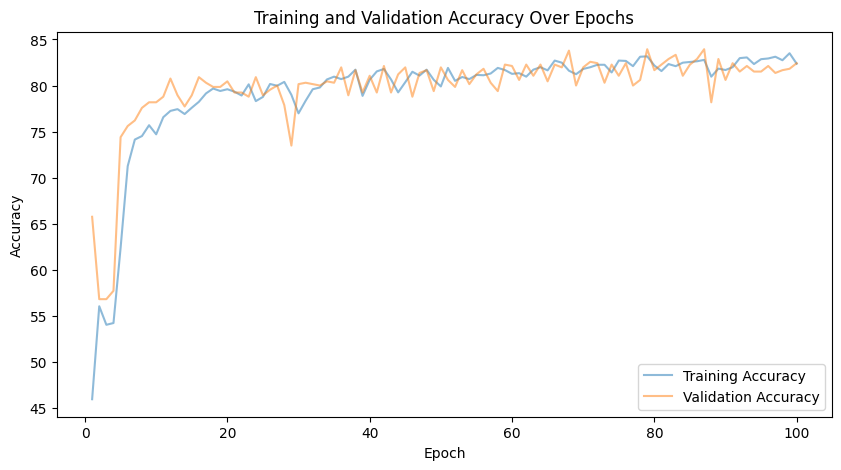

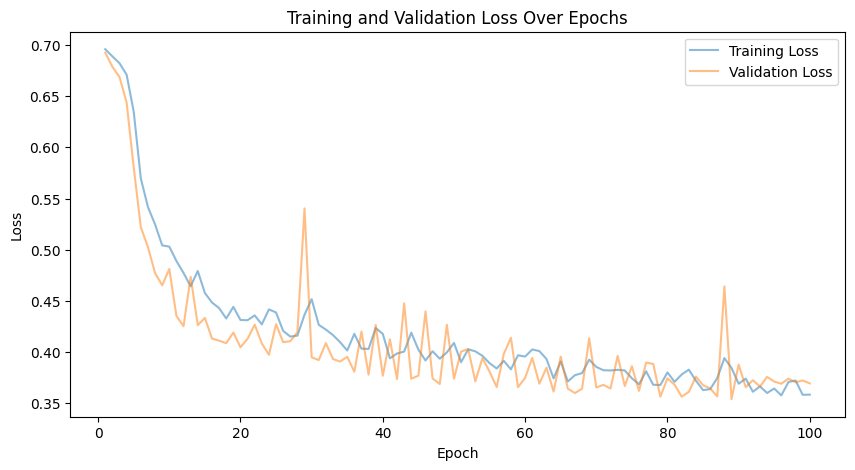

In [14]:
plot_metric('Accuracy', train_accuracies, val_accuracy, epochs=num_epochs)
plot_metric('Loss', train_losses, val_losses, epochs=num_epochs)

In [11]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))

In [12]:
class ImprovedSkinCancerCNN(nn.Module):
    def __init__(self):
        super(ImprovedSkinCancerCNN, self).__init__()
        
        self.conv1 = conv_block(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)  
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.dropout1 = nn.Dropout(p=0.15) 
        
        self.conv2 = conv_block(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.dropout2 = nn.Dropout(p=0.15) 
        
        self.conv3 = conv_block(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1) 
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=2)
        self.dropout3 = nn.Dropout(p=0.15) 
        
        self.conv4 = conv_block(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(p=0.15) 
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(2 * 2 * 512, 512) 
        self.fc2 = nn.Linear(512, 64)  
        self.fc3 = nn.Linear(64, 2)   

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.dropout1(x) 
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x) 
        
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.dropout3(x) 
        
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.dropout4(x) 
        
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

In [17]:
improvedModel = ImprovedSkinCancerCNN().to(device)
optimizer = optim.Adam(improvedModel.parameters(), lr=learning_rate)
train_accuracies, train_losses, val_accuracy, val_losses = train_model(improvedModel, optimizer, criterion, 
                                                                       train_dataloader, test_dataloader, dataset, 
                                                                       num_epochs=num_epochs, device=device)

Epoch [1/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.16batch/s, accuracy=66.4, loss=0.629]


------------------------------
Epoch [2/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.47batch/s, accuracy=64.8, loss=0.575]


------------------------------
Epoch [3/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.26batch/s, accuracy=71.1, loss=0.525]


------------------------------
Epoch [4/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.99batch/s, accuracy=75.8, loss=0.468]


------------------------------
Epoch [5/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.72batch/s, accuracy=82.7, loss=0.352]


------------------------------
Epoch [6/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.79batch/s, accuracy=80.3, loss=0.397]


------------------------------
Epoch [7/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.79batch/s, accuracy=76.5, loss=0.47] 


------------------------------
Epoch [8/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.83batch/s, accuracy=84.2, loss=0.34] 


------------------------------
Epoch [9/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.91batch/s, accuracy=81.1, loss=0.383]


------------------------------
Epoch [10/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.01batch/s, accuracy=84.1, loss=0.334]


------------------------------
Epoch [11/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.73batch/s, accuracy=84.1, loss=0.332]


------------------------------
Epoch [12/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.94batch/s, accuracy=81.1, loss=0.405]


------------------------------
Epoch [13/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.73batch/s, accuracy=84.7, loss=0.332]


------------------------------
Epoch [14/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.10batch/s, accuracy=83.5, loss=0.328]


------------------------------
Epoch [15/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.23batch/s, accuracy=81.8, loss=0.398]


------------------------------
Epoch [16/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.40batch/s, accuracy=78.9, loss=0.461]


------------------------------
Epoch [17/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.43batch/s, accuracy=84.7, loss=0.319]


------------------------------
Epoch [18/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 19.80batch/s, accuracy=83.9, loss=0.318]


------------------------------
Epoch [19/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 19.61batch/s, accuracy=83.5, loss=0.35] 


------------------------------
Epoch [20/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 19.63batch/s, accuracy=84.8, loss=0.321]


------------------------------
Epoch [21/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.57batch/s, accuracy=80.8, loss=0.412]


------------------------------
Epoch [22/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.62batch/s, accuracy=84.7, loss=0.324]


------------------------------
Epoch [23/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 19.90batch/s, accuracy=84.5, loss=0.349]


------------------------------
Epoch [24/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.29batch/s, accuracy=82.9, loss=0.373]


------------------------------
Epoch [25/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.11batch/s, accuracy=85.2, loss=0.3]  


------------------------------
Epoch [26/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.71batch/s, accuracy=84.2, loss=0.325]


------------------------------
Epoch [27/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.09batch/s, accuracy=85.5, loss=0.299]


------------------------------
Epoch [28/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 19.36batch/s, accuracy=82, loss=0.373]


------------------------------
Epoch [29/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 19.88batch/s, accuracy=80.9, loss=0.438]


------------------------------
Epoch [30/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.35batch/s, accuracy=86.2, loss=0.296]


------------------------------
Epoch [31/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.32batch/s, accuracy=83.6, loss=0.332]


------------------------------
Epoch [32/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.24batch/s, accuracy=84.1, loss=0.314]


------------------------------
Epoch [33/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.73batch/s, accuracy=85.6, loss=0.296]


------------------------------
Epoch [34/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.12batch/s, accuracy=82.9, loss=0.341]


------------------------------
Epoch [35/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.82batch/s, accuracy=79.2, loss=0.457]


------------------------------
Epoch [36/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.06batch/s, accuracy=84.5, loss=0.334]


------------------------------
Epoch [37/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.12batch/s, accuracy=81.5, loss=0.395]


------------------------------
Epoch [38/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.37batch/s, accuracy=81.4, loss=0.436]


------------------------------
Epoch [39/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.47batch/s, accuracy=84.1, loss=0.329]


------------------------------
Epoch [40/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.61batch/s, accuracy=86.4, loss=0.326]


------------------------------
Epoch [41/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.48batch/s, accuracy=85.6, loss=0.289]


------------------------------
Epoch [42/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.15batch/s, accuracy=81.2, loss=0.393]


------------------------------
Epoch [43/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.08batch/s, accuracy=85.6, loss=0.282]


------------------------------
Epoch [44/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.40batch/s, accuracy=82.1, loss=0.441]


------------------------------
Epoch [45/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.55batch/s, accuracy=87.1, loss=0.278]


------------------------------
Epoch [46/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.62batch/s, accuracy=79.2, loss=0.558]


------------------------------
Epoch [47/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.43batch/s, accuracy=86.8, loss=0.266]


------------------------------
Epoch [48/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.81batch/s, accuracy=87, loss=0.284] 


------------------------------
Epoch [49/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.54batch/s, accuracy=82, loss=0.462]  


------------------------------
Epoch [50/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.00batch/s, accuracy=87.1, loss=0.292]


------------------------------
Epoch [51/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.82batch/s, accuracy=84.2, loss=0.302]


------------------------------
Epoch [52/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.94batch/s, accuracy=82.7, loss=0.405]


------------------------------
Epoch [53/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.38batch/s, accuracy=86.1, loss=0.306]


------------------------------
Epoch [54/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.33batch/s, accuracy=84.8, loss=0.338]


------------------------------
Epoch [55/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.65batch/s, accuracy=87.3, loss=0.295]


------------------------------
Epoch [56/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.73batch/s, accuracy=86.2, loss=0.297]


------------------------------
Epoch [57/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.58batch/s, accuracy=76.7, loss=0.651]


------------------------------
Epoch [58/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.77batch/s, accuracy=86.4, loss=0.307]


------------------------------
Epoch [59/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.69batch/s, accuracy=83.3, loss=0.388]


------------------------------
Epoch [60/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.07batch/s, accuracy=80.5, loss=0.496]


------------------------------
Epoch [61/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.52batch/s, accuracy=81.5, loss=0.486]


------------------------------
Epoch [62/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.57batch/s, accuracy=86.2, loss=0.313]


------------------------------
Epoch [63/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.55batch/s, accuracy=83.9, loss=0.498]


------------------------------
Epoch [64/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.62batch/s, accuracy=84.2, loss=0.386]


------------------------------
Epoch [65/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.39batch/s, accuracy=87, loss=0.34]  


------------------------------
Epoch [66/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.77batch/s, accuracy=84.8, loss=0.408]


------------------------------
Epoch [67/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.16batch/s, accuracy=85, loss=0.339]  


------------------------------
Epoch [68/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.60batch/s, accuracy=84.5, loss=0.405]


------------------------------
Epoch [69/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.01batch/s, accuracy=85.9, loss=0.351]


------------------------------
Epoch [70/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.93batch/s, accuracy=86.7, loss=0.337]


------------------------------
Epoch [71/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.50batch/s, accuracy=83.9, loss=0.409]


------------------------------
Epoch [72/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.02batch/s, accuracy=82.4, loss=0.478]


------------------------------
Epoch [73/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.41batch/s, accuracy=87, loss=0.319]  


------------------------------
Epoch [74/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.18batch/s, accuracy=81.7, loss=0.516]


------------------------------
Epoch [75/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.57batch/s, accuracy=88, loss=0.328]  


------------------------------
Epoch [76/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.84batch/s, accuracy=85.6, loss=0.341]


------------------------------
Epoch [77/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.55batch/s, accuracy=86.2, loss=0.318]


------------------------------
Epoch [78/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.35batch/s, accuracy=83.2, loss=0.417]


------------------------------
Epoch [79/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.02batch/s, accuracy=86.7, loss=0.299]


------------------------------
Epoch [80/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.81batch/s, accuracy=82.3, loss=0.478]


------------------------------
Epoch [81/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.16batch/s, accuracy=86.8, loss=0.336]


------------------------------
Epoch [82/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.37batch/s, accuracy=86.8, loss=0.334]


------------------------------
Epoch [83/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 17.98batch/s, accuracy=88, loss=0.335]  


------------------------------
Epoch [84/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.57batch/s, accuracy=80, loss=0.641]  


------------------------------
Epoch [85/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.37batch/s, accuracy=87.1, loss=0.338]


------------------------------
Epoch [86/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.25batch/s, accuracy=84.2, loss=0.409]


------------------------------
Epoch [87/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.25batch/s, accuracy=86.7, loss=0.406]


------------------------------
Epoch [88/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.42batch/s, accuracy=87.6, loss=0.312]


------------------------------
Epoch [89/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.75batch/s, accuracy=86.4, loss=0.385]


------------------------------
Epoch [90/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.03batch/s, accuracy=87.4, loss=0.358]


------------------------------
Epoch [91/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 18.91batch/s, accuracy=87.7, loss=0.387]


------------------------------
Epoch [92/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.80batch/s, accuracy=87.6, loss=0.389]


------------------------------
Epoch [93/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.98batch/s, accuracy=87.1, loss=0.364]


------------------------------
Epoch [94/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.54batch/s, accuracy=87.4, loss=0.378]


------------------------------
Epoch [95/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.03batch/s, accuracy=87.3, loss=0.357]


------------------------------
Epoch [96/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 21.02batch/s, accuracy=87.6, loss=0.39] 


------------------------------
Epoch [97/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.06batch/s, accuracy=88, loss=0.382]  


------------------------------
Epoch [98/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.08batch/s, accuracy=88, loss=0.392]  


------------------------------
Epoch [99/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.16batch/s, accuracy=88, loss=0.367]  


------------------------------
Epoch [100/100]


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.21batch/s, accuracy=87.9, loss=0.383]

------------------------------


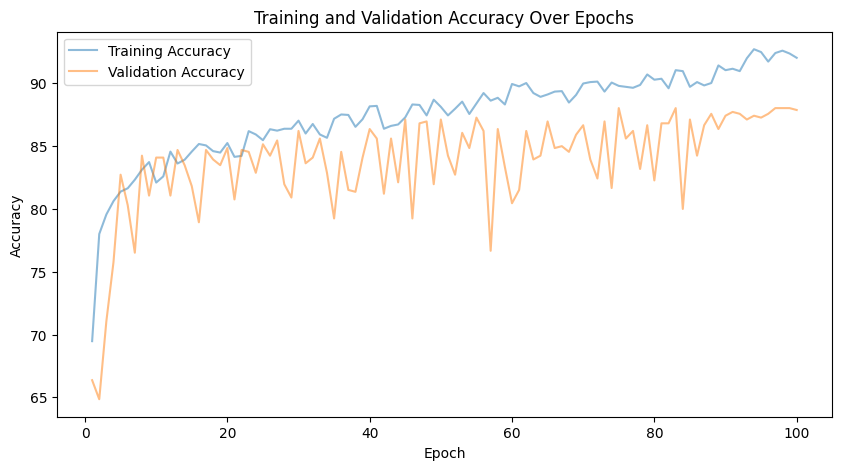

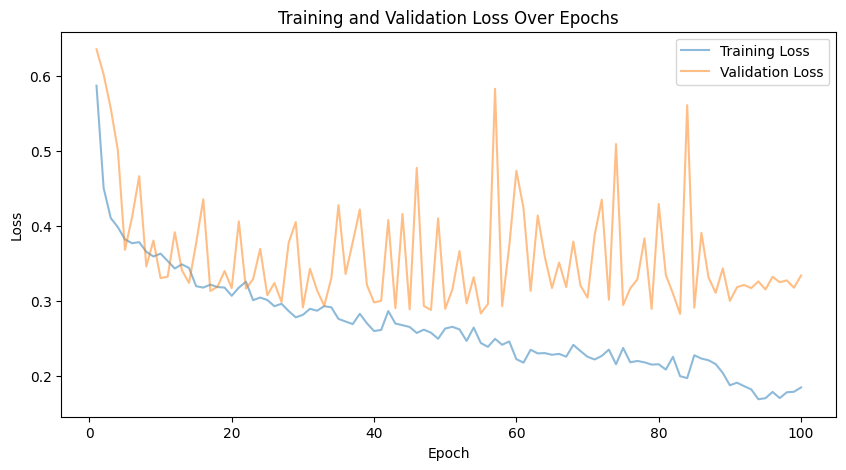

In [18]:
plot_metric('Accuracy', train_accuracies, val_accuracy, epochs=num_epochs)
plot_metric('Loss', train_losses, val_losses, epochs=num_epochs)

In [18]:
from torch import nn

class GoogLeNet(nn.Module):
  def __init__(self, aux_logits=True, num_classes=4):
    super(GoogLeNet, self).__init__()
    assert aux_logits == True or aux_logits == False
    self.aux_logits = aux_logits

    self.conv1 = conv_block(
        in_channels=3,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
    )

    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, num_classes)

    if self.aux_logits:
      self.aux1 = InceptionAux(512, num_classes)
      self.aux2 = InceptionAux(528, num_classes)
    else:
      self.aux1 = self.aux2 = None

  def forward(self, x ):
    x = self.conv1(x)       #
    x = self.maxpool1(x)    #
    x = self.conv2(x)       #
    x = self.maxpool2(x)    #

    x = self.inception3a(x) # 192, 64
    x = self.inception3b(x) # 256, 128
    x = self.maxpool3(x)    # 

    x = self.inception4a(x) #

    # Auxiliary Softmax classifier 1
    if self.aux_logits and self.training:
      aux1 = self.aux1(x)

    x = self.inception4b(x) # 512, 160
    x = self.inception4c(x) # 512, 128
    x = self.inception4d(x) # 512, 112

    # Auxiliary Softmax classifier 2
    if self.aux_logits and self.training:
      aux2 = self.aux2(x)

    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)
    x = self.fc1(x)

    if self.aux_logits and self.training:
      return aux1, aux2, x
    else:
      return x


class Inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
    super(Inception_block, self).__init__()
    self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

    self.branch2 = nn.Sequential(
      conv_block(in_channels, red_3x3, kernel_size=1),
      conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=1),
    )

    self.branch3 = nn.Sequential(
      conv_block(in_channels, red_5x5, kernel_size=1),
      conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
    )

    self.branch4 = nn.Sequential(
      nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
      conv_block(in_channels, out_1x1pool, kernel_size=1),
    )

  def forward(self, x):
    return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)


class InceptionAux(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(InceptionAux, self).__init__()
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.7)
    self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
    self.conv = conv_block(in_channels, 128, kernel_size=1)
    self.fc1 = nn.Linear(2048, 1024)
    self.fc2 = nn.Linear(1024, num_classes)

  def forward(self, x):
    x = self.pool(x)
    x = self.conv(x)
    x = x.reshape(x.shape[0], -1)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x


class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))



In [19]:
custom_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

custom_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    ToTensorAndMove(device),
])

In [20]:
google_net_dataset = Data(device, mode='train', 
                               train_transform=custom_train_transform, val_transform=custom_val_transform)

google_net_dataset.normalize()
google_net_dataset.train_val_split()

google_net_train_dataloader = DataLoader(google_net_dataset, batch_size=batch_size, shuffle=True)
google_net_test_dataloader = DataLoader(google_net_dataset, batch_size=batch_size, shuffle=False)

dataset shape is : (1800, 224, 224, 3)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, optimizer, criterion, train_loader, val_loader, dataset, num_epochs=10, device='cuda'):
    model.to(device)
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []
    
    # Learning rate scheduler based on validation loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)
    
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        
        # Training phase
        dataset.mode = 'train'
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for batch in train_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)
                # print('images.shape: ', images.shape)
                # Forward pass
                optimizer.zero_grad()  
                outputs = model(images)
                
                # Compute loss
                if isinstance(outputs, tuple):  # GoogLeNet produces multiple outputs
                    loss1 = criterion(outputs[0], labels.long())
                    loss2 = criterion(outputs[1], labels.long())
                    loss3 = criterion(outputs[2], labels.long())
                    loss = loss1 + loss2 + loss3
                else:
                    loss = criterion(outputs, labels.long())
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                total_train_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs[2], 1)
                # _, predicted = outputs[0].max(1)  # Use primary output for accuracy
                total_train += labels.size(0)
                correct_train += predicted.eq(labels).sum().item()
                
                # Progress bar update
                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct_train / total_train)
                pbar.update(1)
        
        # Calculate average training loss and accuracy for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100. * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        dataset.mode = 'val'
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
                for batch in val_loader:
                    images, labels = batch['image'].to(device), batch['label'].to(device)
                    # print(images.shape)

                    # Forward pass
                    outputs = model(images)
                    
                    # # Compute loss
                    # if isinstance(outputs, tuple):
                    #     loss1 = criterion(outputs[0], labels.long())
                    #     loss2 = criterion(outputs[1], labels.long())
                    #     loss3 = criterion(outputs[2], labels.long())
                    #     loss = loss1 + loss2 + loss3
                    # else:
                    loss = criterion(outputs, labels.long())
                    
                    total_val_loss += loss.item()
                    
                    # Calculate accuracy
                    _, predicted = outputs.max(1)                    
                    # _, predicted = torch.max(outputs[2], 1)  # Use primary output for accuracy
                    total_val += labels.size(0)
                    correct_val += predicted.eq(labels).sum().item()
                    
                    # Progress bar update
                    pbar.set_postfix(loss=loss.item(), accuracy=100. * correct_val / total_val)
                    pbar.update(1)
        
        # Calculate average validation loss and accuracy for the epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100. * correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_losses.append(avg_val_loss)
        
        # Print epoch results
        print(f"Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        print("-" * 30)
        
        # Step the learning rate scheduler based on validation loss
        scheduler.step(avg_val_loss)
    
    return train_accuracies, train_losses, val_accuracies, val_losses


In [22]:
google_net_model = GoogLeNet().to(device)
optimizer = optim.Adam(google_net_model.parameters(), lr=learning_rate)
train_accuracies, train_losses, val_accuracy, val_losses = train_model(google_net_model, optimizer, criterion, 
                                                                       google_net_train_dataloader, google_net_test_dataloader, 
                                                                       google_net_dataset, num_epochs=num_epochs, device=device)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:07<00:14,  7.35s/batch, accuracy=43.8, loss=1.07]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:14<00:07,  7.31s/batch, accuracy=44.1, loss=1.07]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:19<00:00,  6.36s/batch, accuracy=43.2, loss=1.08]


Training Loss: 1.9015, Accuracy: 69.81%
Validation Loss: 1.0706, Accuracy: 43.18%
------------------------------
Epoch [2/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.92s/batch, accuracy=56.2, loss=0.999]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.97s/batch, accuracy=55.9, loss=1]    

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.08s/batch, accuracy=56.8, loss=0.933]


Training Loss: 1.2311, Accuracy: 81.34%
Validation Loss: 0.9773, Accuracy: 56.82%
------------------------------
Epoch [3/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:07<00:14,  7.02s/batch, accuracy=56.2, loss=1.41]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:14<00:07,  7.10s/batch, accuracy=55.9, loss=1.31]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.16s/batch, accuracy=56.8, loss=1.37]


Training Loss: 1.1229, Accuracy: 82.21%
Validation Loss: 1.3615, Accuracy: 56.82%
------------------------------
Epoch [4/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.89s/batch, accuracy=66, loss=0.729]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.89s/batch, accuracy=69.3, loss=0.592]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.01s/batch, accuracy=69.8, loss=0.666]


Training Loss: 1.1439, Accuracy: 82.82%
Validation Loss: 0.6623, Accuracy: 69.85%
------------------------------
Epoch [5/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.86s/batch, accuracy=75.8, loss=0.496]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.84s/batch, accuracy=80.3, loss=0.36] 

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:17<00:00,  5.97s/batch, accuracy=80.2, loss=0.428]


Training Loss: 1.0128, Accuracy: 83.85%
Validation Loss: 0.4278, Accuracy: 80.15%
------------------------------
Epoch [6/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.89s/batch, accuracy=86.3, loss=0.327]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.91s/batch, accuracy=86.1, loss=0.287]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.10s/batch, accuracy=85.3, loss=0.41] 


Training Loss: 0.9566, Accuracy: 84.64%
Validation Loss: 0.3414, Accuracy: 85.30%
------------------------------
Epoch [7/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.81s/batch, accuracy=67.2, loss=0.642]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.90s/batch, accuracy=69.7, loss=0.527]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:17<00:00,  6.00s/batch, accuracy=69.2, loss=0.726]


Training Loss: 0.9312, Accuracy: 85.40%
Validation Loss: 0.6316, Accuracy: 69.24%
------------------------------
Epoch [8/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.83s/batch, accuracy=84, loss=0.322]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.82s/batch, accuracy=85, loss=0.334]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:17<00:00,  5.95s/batch, accuracy=84.5, loss=0.374]


Training Loss: 0.8756, Accuracy: 86.39%
Validation Loss: 0.3436, Accuracy: 84.55%
------------------------------
Epoch [9/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.80s/batch, accuracy=84.8, loss=0.316]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.81s/batch, accuracy=85.2, loss=0.308]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:17<00:00,  5.94s/batch, accuracy=84.1, loss=0.367]


Training Loss: 0.9234, Accuracy: 85.21%
Validation Loss: 0.3304, Accuracy: 84.09%
------------------------------
Epoch [10/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.86s/batch, accuracy=82.4, loss=0.332]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.81s/batch, accuracy=86.1, loss=0.261]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:17<00:00,  5.94s/batch, accuracy=85.8, loss=0.356]


Training Loss: 0.8688, Accuracy: 85.93%
Validation Loss: 0.3162, Accuracy: 85.76%
------------------------------
Epoch [11/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.83s/batch, accuracy=78.9, loss=0.421]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.82s/batch, accuracy=77.5, loss=0.441]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:17<00:00,  5.95s/batch, accuracy=78.2, loss=0.486]


Training Loss: 0.8333, Accuracy: 86.95%
Validation Loss: 0.4495, Accuracy: 78.18%
------------------------------
Epoch [12/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.83s/batch, accuracy=74.6, loss=0.481]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.83s/batch, accuracy=77.7, loss=0.402]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:17<00:00,  5.96s/batch, accuracy=76.2, loss=0.665]


Training Loss: 0.8234, Accuracy: 87.07%
Validation Loss: 0.5161, Accuracy: 76.21%
------------------------------
Epoch [13/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.81s/batch, accuracy=82.8, loss=0.365]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.82s/batch, accuracy=83.2, loss=0.335]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:17<00:00,  5.96s/batch, accuracy=83.2, loss=0.347]


Training Loss: 0.8110, Accuracy: 87.49%
Validation Loss: 0.3488, Accuracy: 83.18%
------------------------------
Epoch [14/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.90s/batch, accuracy=82.4, loss=0.391]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.90s/batch, accuracy=84.6, loss=0.337]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.02s/batch, accuracy=83.9, loss=0.431]


Training Loss: 0.8308, Accuracy: 86.80%
Validation Loss: 0.3865, Accuracy: 83.94%
------------------------------
Epoch [15/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:07<00:14,  7.02s/batch, accuracy=81.6, loss=0.53]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:14<00:07,  7.04s/batch, accuracy=83.6, loss=0.427]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.13s/batch, accuracy=83.2, loss=0.688]


Training Loss: 0.8574, Accuracy: 87.07%
Validation Loss: 0.5483, Accuracy: 83.18%
------------------------------
Epoch [16/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.96s/batch, accuracy=77.7, loss=0.468]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.96s/batch, accuracy=75.4, loss=0.498]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.07s/batch, accuracy=75.9, loss=0.518]


Training Loss: 0.8335, Accuracy: 86.08%
Validation Loss: 0.4943, Accuracy: 75.91%
------------------------------
Epoch [17/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:07<00:14,  7.15s/batch, accuracy=85.2, loss=0.297]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:14<00:07,  7.05s/batch, accuracy=87.7, loss=0.258]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.17s/batch, accuracy=87, loss=0.399]  


Training Loss: 0.8359, Accuracy: 86.99%
Validation Loss: 0.3179, Accuracy: 86.97%
------------------------------
Epoch [18/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.82s/batch, accuracy=77, loss=0.7]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.82s/batch, accuracy=80.7, loss=0.473]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.02s/batch, accuracy=80, loss=0.685]  


Training Loss: 0.7910, Accuracy: 88.89%
Validation Loss: 0.6194, Accuracy: 80.00%
------------------------------
Epoch [19/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.97s/batch, accuracy=85.9, loss=0.322]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.97s/batch, accuracy=85.4, loss=0.306]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.08s/batch, accuracy=85.2, loss=0.452]


Training Loss: 0.7572, Accuracy: 88.89%
Validation Loss: 0.3598, Accuracy: 85.15%
------------------------------
Epoch [20/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:07<00:14,  7.37s/batch, accuracy=85.9, loss=0.32]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:14<00:07,  7.20s/batch, accuracy=85.2, loss=0.352]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.29s/batch, accuracy=85, loss=0.494]  


Training Loss: 0.7193, Accuracy: 88.32%
Validation Loss: 0.3884, Accuracy: 85.00%
------------------------------
Epoch [21/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:07<00:14,  7.04s/batch, accuracy=85.9, loss=0.297]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:14<00:07,  7.12s/batch, accuracy=85.9, loss=0.285]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.16s/batch, accuracy=85.6, loss=0.366]


Training Loss: 0.6818, Accuracy: 89.95%
Validation Loss: 0.3160, Accuracy: 85.61%
------------------------------
Epoch [22/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.83s/batch, accuracy=85.9, loss=0.284]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.91s/batch, accuracy=86.7, loss=0.327]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.10s/batch, accuracy=86.5, loss=0.281]


Training Loss: 0.6589, Accuracy: 89.38%
Validation Loss: 0.2973, Accuracy: 86.52%
------------------------------
Epoch [23/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:07<00:14,  7.28s/batch, accuracy=85.5, loss=0.404]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:14<00:07,  7.24s/batch, accuracy=84.2, loss=0.476]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:19<00:00,  6.38s/batch, accuracy=84.7, loss=0.471]


Training Loss: 0.6716, Accuracy: 89.57%
Validation Loss: 0.4502, Accuracy: 84.70%
------------------------------
Epoch [24/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.86s/batch, accuracy=89.1, loss=0.267]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.85s/batch, accuracy=88.1, loss=0.304]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:17<00:00,  5.98s/batch, accuracy=87.9, loss=0.49] 


Training Loss: 0.7541, Accuracy: 88.40%
Validation Loss: 0.3536, Accuracy: 87.88%
------------------------------
Epoch [25/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:07<00:14,  7.20s/batch, accuracy=75, loss=0.793]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:14<00:07,  7.19s/batch, accuracy=77.7, loss=0.573]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.28s/batch, accuracy=78, loss=0.727]  


Training Loss: 0.6642, Accuracy: 90.18%
Validation Loss: 0.6975, Accuracy: 78.03%
------------------------------
Epoch [26/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:07<00:14,  7.17s/batch, accuracy=82.8, loss=0.375]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:14<00:07,  7.26s/batch, accuracy=83.8, loss=0.344]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:19<00:00,  6.39s/batch, accuracy=83.2, loss=0.416]


Training Loss: 0.7008, Accuracy: 89.50%
Validation Loss: 0.3785, Accuracy: 83.18%
------------------------------
Epoch [27/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.87s/batch, accuracy=77.3, loss=0.971]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.89s/batch, accuracy=78.7, loss=0.895]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.02s/batch, accuracy=79.7, loss=1.05] 


Training Loss: 0.6549, Accuracy: 90.33%
Validation Loss: 0.9718, Accuracy: 79.70%
------------------------------
Epoch [28/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:07<00:14,  7.13s/batch, accuracy=84, loss=0.366]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:14<00:07,  7.12s/batch, accuracy=85, loss=0.327]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:18<00:00,  6.17s/batch, accuracy=85.3, loss=0.324]


Training Loss: 0.6504, Accuracy: 90.37%
Validation Loss: 0.3393, Accuracy: 85.30%
------------------------------
Epoch [29/100]


Validation:   0%|          | 0/3 [00:00<?, ?batch/s]

torch.Size([256, 3, 224, 224])


Validation:  33%|███▎      | 1/3 [00:06<00:13,  6.84s/batch, accuracy=89.1, loss=0.254]

torch.Size([256, 3, 224, 224])


Validation:  67%|██████▋   | 2/3 [00:13<00:06,  6.86s/batch, accuracy=87.9, loss=0.289]

torch.Size([148, 3, 224, 224])


Validation: 100%|██████████| 3/3 [00:17<00:00,  5.98s/batch, accuracy=87.3, loss=0.396]


Training Loss: 0.6429, Accuracy: 89.69%
Validation Loss: 0.3131, Accuracy: 87.27%
------------------------------
Epoch [30/100]


Training:  27%|██▋       | 3/11 [00:42<01:54, 14.30s/batch, accuracy=91, loss=0.711]


KeyboardInterrupt: 